In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("/content/drive/MyDrive/오지민/과제2/train.csv")

In [31]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


# 결측치 확인 및 처리

In [32]:
# 결측치 확인 및 처리
df.isnull().sum()
# 없음

,0
ID,0
나이,0
키(cm),0
몸무게(kg),0
BMI,0
시력,0
충치,0
공복 혈당,0
혈압,0
중성 지방,0


# 이상치 확인 및 처리

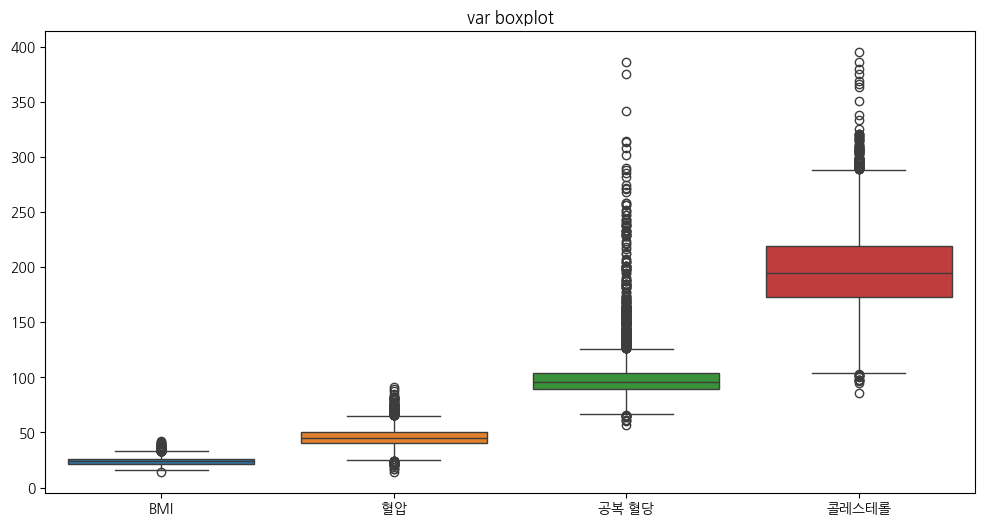

In [33]:
# 이상치 탐색 (박스플롯, 히스토그램 등)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['BMI', '혈압', '공복 혈당', '콜레스테롤']])
plt.title('var boxplot')
plt.show()


# WARNING:matplotlib.font_manager:findfont: Font family 'NanumBarunGothic' not found. 발생 시에는 "런타임 -> 세션 다시시작 -> 처음부터 실행 해주세요"

### 결과해석
BMI, 혈압: 상대적으로 이상치가 적고 정상 범위에 대부분 분포

공복 혈당, 콜레스테롤: 상위 범위에서 여러 이상치(매우 높거나 낮은 값)가 매우 많이 확인됨

- 이상치 처리방법은 대표적으로 아래 4가지
1. 이상치 미처리(원본 유지)
2. IQR/사분위수 기반 부분 제거
3. 클리핑/값 대체
4. 로그 변환 등 스케일링

그 중 로그 변환 등 스케일링을 수행하겠음.


의료 데이터(콜레스테롤, 혈당 등)는 한쪽으로 치우친 분포와 극단값이 많음

로그 변환을 하면 분포가 정규분포에 가까워지고, 이상치의 영향이 완화되어 모델이 더 안정적으로 학습함

In [34]:
# 로그 변환
df = df.copy()
df['콜레스테롤'] = np.log1p(df['콜레스테롤'])

# 변수 간 상관관계 시각화

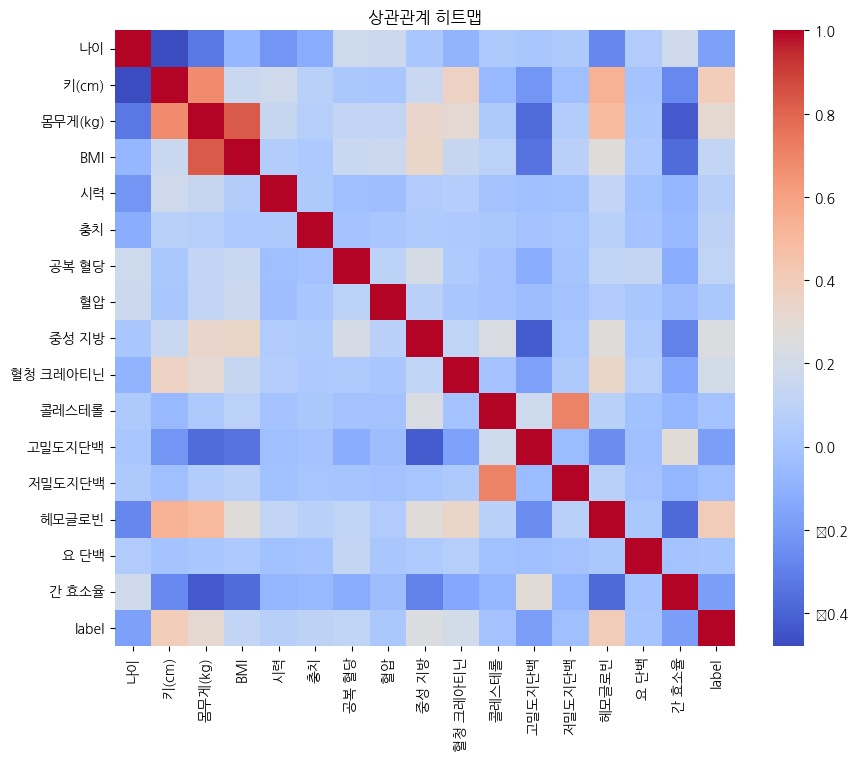

In [35]:
# 숫자형 컬럼만 선택
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title('상관관계 히트맵')
plt.show()

### 결과 해석
1. label(흡연여부)와 강한 상관변수 없음. 여러 변수를 조합하는 것이 필요

2. 강한 음/양의 상관계수 조합해서 활용하기(ex. 콜레스테롤-HDL)

3. 상관관계가 높은 피처(몸무게와 BMI, 콜레스테롤과 저밀도지단백)는 다중공선성 문제로 예측력이 저하될 수 있어서, 필요시 축소(PCA) 고려

# 주요 변수 리스트 및 피처 엔지니어링

In [36]:
# 주요 변수 리스트
features = [
    '나이', '키(cm)', '몸무게(kg)', 'BMI', '시력', '충치', '공복 혈당', '혈압',
    '중성 지방', '혈청 크레아티닌', '콜레스테롤', '고밀도지단백', '저밀도지단백',
    '헤모글로빈', '요 단백', '간 효소율'
]

# 피처 엔지니어링

# BMI(체질량지수)는 비만도와 건강 위험도를 나타내는 대표적 지표입니다. 단순 BMI 외에 비선형 변환(지수승)을 적용하면 BMI가 높은 사람의 건강 위험도를 더 강조할 수 있습니다. 실제로 비만도가 높을수록 흡연과 건강 문제의 상관성이 커질 수 있습니다
df['BMI_pow'] = df['BMI'] ** 1.1

# 혈압과 BMI는 모두 심혈관 건강과 관련된 변수입니다. 두 값을 비율로 조합하면, 체중 대비 혈압이 비정상적으로 높은 경우(예: 마른 고혈압 등)나 BMI가 높으면서 혈압도 높은 경우를 더 잘 포착할 수 있습니다. 이런 조합은 흡연자에서 흔히 나타나는 건강 이상 신호일 수 있습니다.
df['bp_bmi_ratio'] = df['혈압'] / df['BMI']

# LDL(저밀도지단백)은 '나쁜 콜레스테롤', HDL(고밀도지단백)은 '좋은 콜레스테롤'로 불립니다. 이 비율이 높을수록 심혈관 질환 위험이 커지며, 흡연은 LDL을 높이고 HDL을 낮추는 경향이 있습니다. 따라서 이 비율은 흡연 여부 예측에 중요한 피처가 됩니다.
df['LDL_HDL_ratio'] = df['저밀도지단백'] / (df['고밀도지단백'] + 1e-5)

# 총 콜레스테롤과 중성지방은 모두 혈액 내 지방 성분입니다. 이 비율은 대사 이상이나 건강 위험도를 나타내며, 흡연자는 대사 이상이 더 흔하게 나타날 수 있습니다.
df['chol_tg_ratio'] = df['콜레스테롤'] / (df['중성 지방'] + 1e-5)

# 공복 혈당은 당뇨 위험과 관련이 있고, BMI와 함께 보면 체중 대비 혈당 이상 여부를 파악할 수 있습니다. 흡연은 인슐린 저항성과 당뇨 위험을 높일 수 있으므로, 이 비율은 흡연자 예측에 도움이 됩니다.
df['glucose_bmi_ratio'] = df['공복 혈당'] / df['BMI']

# 혈청 크레아티닌은 신장 기능을 반영하는 지표입니다. BMI로 정규화하면 체중에 따른 신장 기능 이상을 더 잘 포착할 수 있습니다. 흡연은 신장 기능 저하와도 관련이 있습니다.
df['creatinine_norm'] = df['혈청 크레아티닌'] / df['BMI']

# 헤모글로빈은 산소 운반 능력을 나타내며, 몸무게로 나누면 체중 대비 산소 운반 능력의 이상 여부를 파악할 수 있습니다. 흡연자는 산소 운반 능력에 영향을 받을 수 있습니다.
df['hemoglobin_weight_ratio'] = df['헤모글로빈'] / df['몸무게(kg)']

# 간 효소율은 간 기능 이상을 나타내는 지표입니다. 로그 변환은 값의 분포를 정규화하고, 극단값(이상치)의 영향을 줄여줍니다. 흡연은 간 기능 저하와도 관련이 있으므로, 이 피처는 흡연자 예측에 유용합니다.
df['log_liver_enzyme'] = np.log1p(df['간 효소율'])

# 합치기
features_extended = features + [
    'BMI_pow', 'bp_bmi_ratio', 'LDL_HDL_ratio', 'chol_tg_ratio',
    'glucose_bmi_ratio', 'creatinine_norm', 'hemoglobin_weight_ratio',
    'log_liver_enzyme'
]

# 독립/종속변수 분리, 데이터 분할

In [37]:
# 독립변수, 종속변수 분리
X = df[features_extended]
y = df['label'].astype(int)  # 분류 문제이므로 정수형으로

# 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 하이퍼 파라미터 튜닝

Grid Search를 통해 최적 하이퍼파라미터를 찾기

한번 실행 후 결과 얻었으니 주석처리

In [38]:
# # 파이프라인 설정
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
# ])

# # 하이퍼파라미터 후보 설정
# param_grid = {
#     'logreg__C': [0.01, 0.1, 1, 10, 100],
#     'logreg__penalty': ['l1', 'l2'],
#     'logreg__solver': ['liblinear', 'saga']
# }

# # GridSearchCV 설정 (5겹 교차검증)
# grid_search = GridSearchCV(
#     pipeline, param_grid,
#     cv=5, scoring='accuracy',
#     n_jobs=-1, verbose=1
# )

# # 학습 데이터는 X_train, y_train으로 가정
# grid_search.fit(X_train, y_train)

# print("Best parameters found:", grid_search.best_params_)
# print("Best accuracy:", grid_search.best_score_)

# # 최적 모델로 검증셋 평가
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_valid)

# from sklearn.metrics import accuracy_score, classification_report
# print("Validation accuracy:", accuracy_score(y_valid, y_pred))
# print(classification_report(y_valid, y_pred))

# 하이퍼 파라미터 튜닝 결과
C = 0.1 (규제 강도)

penalty = l1 (L1 규제)

solver = saga (최적화 알고리즘)

이 하이퍼파라미터로 학습한 모델의 검증 정확도는 약 73.79%이며, 분류 성능도 이전보다 안정적으로 향상된 것을 볼 수 있습니다.



```
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best accuracy: 0.70625
Validation accuracy: 0.7378571428571429
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       886
           1       0.60      0.82      0.70       514

    accuracy                           0.74      1400
   macro avg       0.74      0.76      0.73      1400
weighted avg       0.77      0.74      0.74      1400

```



하지만 흡연자 (1) 의 precision이 상대적으로 낮은 경향이 있다.

# SMOTE 오버 샘플링 기법 적용

흡연자의 precision을 높이기 위한 시도

In [39]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# SMOTE 오버샘플링 적용
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [40]:
# 파이프라인 설정 학습
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='saga',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

final_pipeline.fit(X_train_res, y_train_res)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    random_state=42, solver='saga'))])

In [41]:
# 검증 데이터 예측 및 평가
y_pred = final_pipeline.predict(X_valid)
y_pred_proba = final_pipeline.predict_proba(X_valid)[:, 1]

print('Final Validation Accuracy:', accuracy_score(y_valid, y_pred))
print('Final Validation AUC:', roc_auc_score(y_valid, y_pred_proba))
print(classification_report(y_valid, y_pred))

Final Validation Accuracy: 0.7435714285714285
Final Validation AUC: 0.803313102212541
              precision    recall  f1-score   support

           0       0.87      0.70      0.78       886
           1       0.61      0.82      0.70       514

    accuracy                           0.74      1400
   macro avg       0.74      0.76      0.74      1400
weighted avg       0.78      0.74      0.75      1400



# test 데이터 예측

In [44]:
# test 데이터 불러오기
test = pd.read_csv("/content/drive/MyDrive/오지민/과제2/test.csv")

# train에서 사용한 피처 엔지니어링을 test에도 동일하게 적용
test = test.copy()
test['콜레스테롤'] = np.log1p(test['콜레스테롤'])
test['BMI_pow'] = test['BMI'] ** 1.1
test['bp_bmi_ratio'] = test['혈압'] / (test['BMI'] + 1e-5)
test['LDL_HDL_ratio'] = test['저밀도지단백'] / (test['고밀도지단백'] + 1e-5)
test['chol_tg_ratio'] = test['콜레스테롤'] / (test['중성 지방'] + 1e-5)
test['glucose_bmi_ratio'] = test['공복 혈당'] / (test['BMI'] + 1e-5)
test['creatinine_norm'] = test['혈청 크레아티닌'] / (test['BMI'] + 1e-5)
test['hemoglobin_weight_ratio'] = test['헤모글로빈'] / (test['몸무게(kg)'] + 1e-5)
test['log_liver_enzyme'] = np.log1p(test['간 효소율'])


# features_extended 리스트는 train과 동일하게 사용
features_extended = [
    '나이', '키(cm)', '몸무게(kg)', 'BMI', '시력', '충치', '공복 혈당', '혈압',
    '중성 지방', '혈청 크레아티닌', '콜레스테롤', '고밀도지단백', '저밀도지단백',
    '헤모글로빈', '요 단백', '간 효소율',
    'BMI_pow', 'bp_bmi_ratio', 'LDL_HDL_ratio', 'chol_tg_ratio',
    'glucose_bmi_ratio', 'creatinine_norm', 'hemoglobin_weight_ratio', 'log_liver_enzyme'
]

X_test_final = test[features_extended]

# 학습된 파이프라인(final_pipeline)으로 예측
y_test_pred = final_pipeline.predict(X_test_final)

# 예측 결과를 test 데이터의 ID와 함께 저장
submission = pd.DataFrame({
    'ID': test['ID'],
    'label': y_test_pred
})

# 제출 파일로 저장
submission.to_csv('submission.csv', index=False)

In [45]:
# submission.csv 파일 확인
sub = pd.read_csv("/content/submission.csv")
sub

,ID,label
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,0
...,...,...
2995,TEST_2995,0
2996,TEST_2996,0
2997,TEST_2997,0
2998,TEST_2998,1


In [51]:
print(sub['label'].value_counts())

label
0    1532
1    1468
Name: count, dtype: int64
